## 3D CNN Instance Segmentation of Proteins in Cryo-ET Tomograms

This tutorial guides you through the process of training 3D U-Nets for instance segmentation of proteins in Cryo-ET tomograms. It draws inspiration from the segmentation framework introduced by E. Moebel and co-authors in [DeepFinder](https://www.nature.com/articles/s41592-021-01275-4). However, this repository introduces new developments in model architectures, data augmentations, and efficient model training, with support for datasets available on both local and remote resources.

n this notebook, we demonstrate how to utilize this infrastructure to predict the 3D coordinates of six proteins of varying sizes, provided by the [CryoET Dataportal](https://cryoetdataportal.czscience.com) (Dataset ID: [10439](https://cryoetdataportal.czscience.com/datasets/10439)). This is a synthetic dataset generated by [Polnet](https://github.com/anmartinezs/polnet/tree/main), allowing us to reliably use the ground truth coordinates to evaluate the accuracy of our model.

The tutorial is structured into two main components:

1. Data Preparation: Generating target volumes that the network will use to predict coordinates.
2. Model Training: Training the 3D U-Net model.

By following this tutorial, you will gain insights into preparing data, training a 3D U-Net model for the instance segmentation of proteins in Cryo-ET tomograms.

#### Step 1 - Data Preparation: Generate Targets for Training and Predicting Coordinates of Proteins in a Tomogram 

In this step, we will prepare the target data necessary for training our model and predicting the coordinates of proteins within a tomogram. 

We will use the [Copick](https://github.com/uermel/copick) tool to manage the filesystem, extract tomogram IDs, and create spherical targets corresponding to the locations of proteins. The key tasks performed in this cell include:

* Loading Parameters: We define the size of the target spheres, specify the CoPick path, voxel size, target file name, and user ID.
* Generating Targets: For each tomogram, we extract particle coordinates, reset the target volume, generate spherical targets based on these coordinates, and save the target data in OME Zarr format.

In [1]:
from deepfindET.entry_points import step1
from deepfindET.utils import copick_tools
import matplotlib.pyplot as plt
import copick

%matplotlib inline

################## Input Parameters #################

# Config File
config = 'config_10439.json'

# Query Tomogram
voxel_size = 10 
tomogram_algorithm = 'wbp'

# Output Name for the Segmentation Targets
out_name = 'remotetargets'
out_user_id = 'deepfindET'
out_session_id = '1'

# Read Copick Directory
copickRoot = copick.from_file(config)

# Query Train Protein Coordiantes and any Associated Segmentations
train_targets = {}

# Define protein targets with their respective radii
# We can Provide two forms of inputs, either 
# ('protein-name',radius) or ('protein-name', 'user-id', 'session-id', 'radius')
targets = [
    ('adp-mitochondrial', None, None, 7.5), 
    ('alkaline-phosphate', None, None, 7.5), 
    ('nucleosome', None, None, 6.5), 
    ('ribosome', None, None, 11), 
    ('vault', None, None, 13), 
    ('virus-like-capsid', None, None, 11)
]

# Set run_ids to None, indicating that targets will be generated for the entire CoPick project by default.
# If specific Run-IDs were provided, this variable would contain a list of those IDs.
run_ids = None

Now let's generate the targets for our model. There are two methods to generate the training targets: either through a function call or via a CLI command. In this notebook, we'll use the function, but for those interested, the equivalent CLI command is `step1 create`. To see all available options, you can run `step1 create --help`.

Targets can be created for specific user-defined Run-IDs or for the entire CoPick project. If no Run-IDs are specified, DeepFindET will default to creating targets for the entire project.

In [ ]:
# Generate train target information
for t in targets:
    obj_name, user_id, session_id, radius = t
    info = {
        "label": copickRoot.get_object(obj_name).label,
        "user_id": user_id,
        "session_id": session_id,
        "radius": radius,
        "is_particle_target": True,
    }
    train_targets[obj_name] = info


# Define segmentation target (e.g., membrane)
seg_targets = [('membrane', None, None)]

# Generate segmentation target information
for s in seg_targets:
    obj_name, user_id, session_id = s
    info = {
        "label": copickRoot.get_object(obj_name).label,
        "user_id": user_id,
        "session_id": session_id,
        "radius": None,       
        "is_particle_target": False,                 
    }
    train_targets[obj_name] = info

# Call the create_train_targets function from step1 to generate the training targets for the 3D U-Net model.
# The function will use the parameters defined in the previous cells and the following inputs:
step1.create_train_targets(
    config,              # The configuration file path specifying various settings and parameters for the project.
    train_targets,       # A dictionary containing the target information for each protein or object to be segmented.
    run_ids,             # The list of Run-IDs for which to generate targets. None means targets for the entire project.
    voxel_size,          # The voxel size to be used in the tomogram data.
    tomogram_algorithm,  # The reconstruction algorithm used for the tomograms, e.g., 'wbp' (weighted back projection).
    out_name,            # The output name for the generated segmentation targets.
    out_user_id,         # The user ID under which the output targets will be saved.
    out_session_id,      # The session ID associated with the output, typically used for tracking purposes.
)

#### (Optional) Visualize the Tomogram and Target Volumes 

In [11]:
# Option 1: Query All RunIDs
# Retrieve all available Run-IDs from the CoPick project. This generates a list of Run-IDs by iterating over all runs in copickRoot.
run_ids = [run.name for run in copickRoot.runs]

# Option 2: Manually Specify Specific Run
# Define a specific Run-ID manually. This is useful for extracting volumes for a specific run.
runID = '16185'

# Retrieve the specific run object from CoPick using the manually specified Run-ID.
copick_run = copickRoot.get_run(runID)

# Extract the segmentation target associated with the specified run.
# The function get_copick_segmentation retrieves the segmentation data (e.g., target volume) based on the run object,
# segmentation name, user ID, and session ID.
train_target = copick_tools.get_copick_segmentation(
    copick_run,                 # The run object obtained from CoPick for the specific Run-ID.
    segmentationName='remotetargets',  # The name of the segmentation target to retrieve.
    userID='deepfindET',        # The user ID under which the segmentation data is saved.
    sessionID='1'               # The session ID associated with the segmentation data.
)

# Retrieve the tomogram associated with the specified Run-ID from the CoPick project.
# The function get_copick_tomogram extracts the tomogram data, using the voxel size, algorithm, and Run-ID.
train_tomogram = copick_tools.get_copick_tomogram(
    copickRoot,                 # The root object for the CoPick project, containing all runs and associated data.
    voxelSize=voxel_size,       # The voxel size to be used for retrieving the tomogram.
    tomoAlgorithm='wbp',        # The reconstruction algorithm used for the tomogram, e.g., 'wbp' (weighted back projection).
    tomoID=runID                # The specific Run-ID for which the tomogram is being retrieved.
)

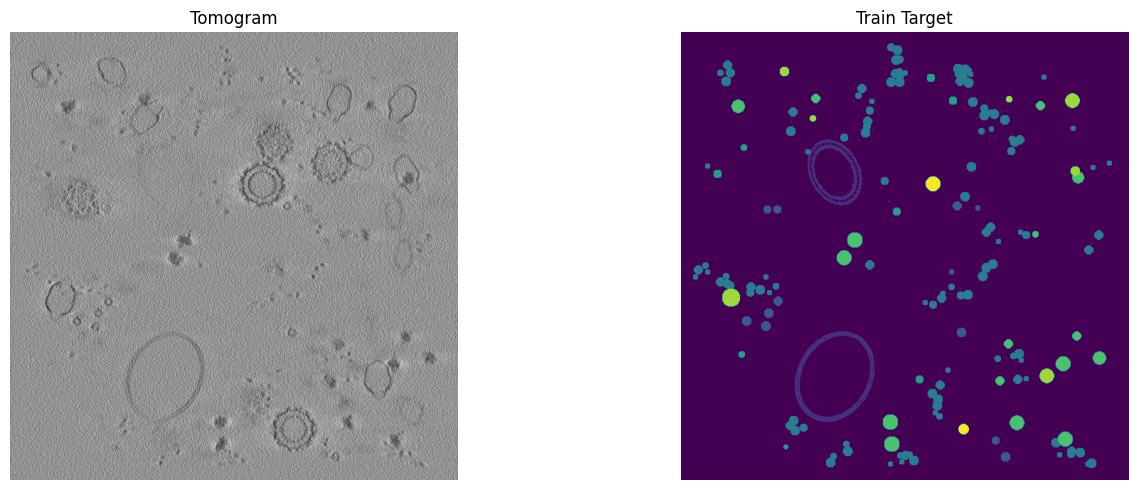

In [12]:
# Plot the images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Tomogram')
plt.imshow(train_tomogram[90,],cmap='gray')
plt.axis('off')

# Original Image
plt.subplot(1, 2, 2)
plt.title('Train Target')
plt.imshow(train_target[90,])
plt.axis('off')

plt.tight_layout()
plt.show()

### Step 2: Traing DeepFindET 3D CNN Model

In this step, we will configure and train the DeepFinder 3D CNN model, leveraging the targets generated in the previous step. This model is designed to classify different protein types and accurately predict their 3D coordinates within tomograms. By the end of this step, the model will be capable of segmenting and identifying proteins in complex 3D Cryo-ET datasets.

In [2]:
from deepfindET.entry_points import step2

# Specify the directory where the training results will be saved.
training_output_path = 'train_results'

# Set the model architecture to Residual U-Net ('res_unet'), 
# which combines U-Net with residual connections to improve training.
model_name = 'res_unet'

# Set to None to indicate that the model will betrained from scratch 
# without using pre-trained weights.
model_pre_weights = None

# Number of classes the model will predict. 
# Here, we are working with 8 different classes (6 proteins + membrane + background).
n_class = 8

# Input dimension size of the 3D volumes in voxels. Each input is a 72x72x72 voxel cube -- (72 Å)^3.
dim_in = 72  # [voxels]

2024-09-02 19:12:05.602557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 19:12:05.616039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 19:12:05.629190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 19:12:05.633011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 19:12:05.643993: I tensorflow/core/platform/cpu_feature_guar

#### Launch Model Training

Similarly to the target creation command, initiating the training process for the DeepFindET 3D U-Net model can be done through a CLI call to train a model. The equivalent CLI command is step2 train. You can view all available options by running:

`step2 train --help` 

**Dataset Splitting**  
If specific runs for validation and training aren't provided, the entire dataset in the Copick directory will automatically be split into 70/15/15 for training, validation, and testing, respectively.

**Training Strategy**  
In this setup, the training process is inspired by the methodology described in the DeepFinder paper. To address data imbalance issues commonly encountered in semantic segmentation tasks, bootstrapping is employed. Additionally, a multi-class Tversky loss function is utilized to improve performance on imbalanced datasets.

**Model Architecture**  
Users have the flexibility to experiment with various model architectures, including traditional U-Nets (`unet`), residual U-Nets (`res_unet`), and attention U-Nets (`attn_res_unet`). This versatility allows fine-tuning the model to better fit the specific characteristics of the dataset being used.

**Initiating Training**  
Below is the code snippet to initiate the training of the DeepFindET 3D U-Net model. The training parameters will automatically be saved in the training_output_path as `experiment_config.json`

In [3]:
# Initiate the training of the DeepFindET 3D U-Net model.
step2.train_model(
    config,                 # Configuration file with various settings for the project.
    voxel_size,             # Voxel size used in the tomogram data.
    tomogram_algorithm,     # Reconstruction algorithm used for the tomograms (e.g., 'wbp').
    targets,                 # Target data for training the model.
    training_output_path,   # Path where the training outputs will be saved.
    model_name,             # Model architecture name ('res_unet').
    model_pre_weights,      # Pre-trained weights (None for training from scratch).
    n_class,                # Number of classes for segmentation (8 in this case).
    path_valid=None,        # Path to validation data (None means internal splitting may be used).
    dim_in=dim_in,          # Input dimension size in voxels.
    n_sub_epoch=10,         # Number of epochs to train on tomograms prior to swapping to a new set of tomograms.
    sample_size=5,          # Number of tomograms to extract per epoch.
    batch_size=10,          # Batch size used during training.
    epochs=50,              # Total number of training epochs.
    steps_per_epoch=150,    # Number of steps per epoch.
    n_valid=20,             # Number of validation samples.
    model_filters=[48, 64, 128],  # Filters in the convolutional layers at each level of the U-Net.
    model_dropout=0,        # Dropout rate (0 means no dropout applied).
    target_name="remotetargets",    # Name of the segmentation targets.
    target_user_id="deepfindET",  # User ID for the segmentation labels.
    target_session_id="1",    # Session ID associated with the labeling.
    valid_tomo_ids=None,    # List of tomogram IDs for validation.
    train_tomo_ids=None,     # List of tomogram IDs for training.
    class_weights=(('membrane',1),('adp-mitochondrial',3000),('alkaline-phosphate',3000),
                   ('nucleosome',3000),('ribosome',750),('vault',500),('virus-like-capsid',750))
)

2024-09-02 19:12:31.416815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78784 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:1b:00.0, compute capability: 9.0



Training res_unet with Randomly Initialized Weights

Physical devices cannot be modified after being initialized
Loading Targets and Tomograms for the Following Runs: ['16191', '16176', '16198', '16196', '16195']


100%|█████████████████████████████████████████████| 5/5 [00:47<00:00,  9.53s/it]


Loading Targets and Tomograms for the Following Runs: ['16183', '16185', '16184', '16180', '16189']


100%|█████████████████████████████████████████████| 5/5 [00:48<00:00,  9.64s/it]


Configuration saved to train_results3/experiment_config.json

Training Parameters:  {
    "input": {
        "config_path_train": "config_10439.json",
        "config_path_valid": null,
        "target_name": "remotetargets",
        "target_user_id": "deepfindET",
        "target_session_id": "1"
    },
    "output": {
        "out_dir": "train_results3",
        "classes": {
            "membrane": 1,
            "adp-mitochondrial": 2,
            "alkaline-phosphate": 3,
            "nucleosome": 4,
            "ribosome": 5,
            "vault": 6,
            "virus-like-capsid": 7
        }
    },
    "network_architecture": {
        "architecture": "res_unet",
        "layers": [
            48,
            64,
            128
        ],
        "dropout_rate": 0.0
    },
    "training_params": {
        "n_class": 8,
        "dim_in": 72,
        "batch_size": 10,
        "epochs": 50,
        "steps_per_epoch": 150,
        "steps_per_valid": 10,
        "num_sub_epoch": 10,

I0000 00:00:1725329695.073885  523368 service.cc:146] XLA service 0x15205000dca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725329695.073945  523368 service.cc:154]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2024-09-02 19:14:55.226411: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-02 19:14:56.669958: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-02 19:15:06.839668: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[10,112,72,72,72]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[10,48,72,72,72]{4,3,2,1,0}, f16[48,112,3,3,3]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","w

4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step  step - accuracy: 0.6563 - loss: 92
150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 596ms/step - accuracy: 0.6572 - loss: 926.8503 - val_accuracy: 0.2130 - val_loss: 7.4928 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9099 - loss: 6
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 429ms/step - accuracy: 0.9099 - loss: 659.6016 - val_accuracy: 0.8988 - val_loss: 5.5371 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9285 - loss: 5
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 427ms/step - accuracy: 0.9285 - loss: 533.2722 - val_accuracy: 0.8956 - val_loss: 4.8392 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/stepstep - accuracy: 0.9402 - loss: 4
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 403ms/step - accuracy: 0.9402 - loss: 463.6790 - val_accuracy: 0.9283 - val_loss: 4.8309 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/stepstep - accuracy: 0.9436 - lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Swapping datasets at epoch 10
Loading Targets and Tomograms for the Following Runs: ['16197', '16194', '16177', '16179', '16198']


100%|█████████████████████████████████████████████| 5/5 [00:48<00:00,  9.77s/it]


Loading Targets and Tomograms for the Following Runs: ['16184', '16180', '16189', '16183', '16185']


100%|█████████████████████████████████████████████| 5/5 [00:44<00:00,  8.84s/it]


150/150 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9536 - loss: 361.3037 - val_accuracy: 0.9440 - val_loss: 3.3343 - learning_rate: 1.0000e-04
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9566 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 368ms/step - accuracy: 0.9566 - loss: 351.4214 - val_accuracy: 0.9443 - val_loss: 3.5757 - learning_rate: 1.0000e-04
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/stepstep - accuracy: 0.9545 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 365ms/step - accuracy: 0.9546 - loss: 351.7198 - val_accuracy: 0.9480 - val_loss: 3.5322 - learning_rate: 1.0000e-04
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9578 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 364ms/step - accuracy: 0.9578 - loss: 345.6893 - val_accuracy: 0.9122 - val_loss: 3.7102 - learning_rate: 1.0000e-04
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/stepstep - accuracy: 0.9580 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9580 - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Swapping datasets at epoch 20
Loading Targets and Tomograms for the Following Runs: ['16198', '16173', '16182', '16197', '16187']


100%|█████████████████████████████████████████████| 5/5 [00:43<00:00,  8.73s/it]


Loading Targets and Tomograms for the Following Runs: ['16180', '16183', '16184', '16189', '16185']


100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.49s/it]


150/150 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9594 - loss: 308.6333 - val_accuracy: 0.9296 - val_loss: 4.1485 - learning_rate: 1.0000e-04
Epoch 21/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9644 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 366ms/step - accuracy: 0.9644 - loss: 300.2197 - val_accuracy: 0.9444 - val_loss: 3.6149 - learning_rate: 1.0000e-04
Epoch 22/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9606 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 365ms/step - accuracy: 0.9606 - loss: 313.7367 - val_accuracy: 0.9514 - val_loss: 3.0202 - learning_rate: 1.0000e-04
Epoch 23/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/stepstep - accuracy: 0.9631 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9631 - loss: 304.2559 - val_accuracy: 0.9447 - val_loss: 3.7340 - learning_rate: 1.0000e-04
Epoch 24/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/stepstep - accuracy: 0.9630 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9630 - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Swapping datasets at epoch 30
Loading Targets and Tomograms for the Following Runs: ['16178', '16194', '16192', '16190', '16191']


100%|█████████████████████████████████████████████| 5/5 [00:45<00:00,  9.09s/it]


Loading Targets and Tomograms for the Following Runs: ['16189', '16180', '16183', '16185', '16184']


100%|█████████████████████████████████████████████| 5/5 [00:48<00:00,  9.66s/it]


150/150 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9647 - loss: 283.8963 - val_accuracy: 0.9332 - val_loss: 3.8183 - learning_rate: 1.0000e-04
Epoch 31/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/stepstep - accuracy: 0.9658 - loss: 2
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 0.9658 - loss: 283.0348 - val_accuracy: 0.9499 - val_loss: 3.2784 - learning_rate: 1.0000e-04
Epoch 32/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepstep - accuracy: 0.9651 - loss: 2
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9651 - loss: 296.1477 - val_accuracy: 0.9426 - val_loss: 3.9707 - learning_rate: 1.0000e-04
Epoch 33/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9648 - loss: 3
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 367ms/step - accuracy: 0.9648 - loss: 308.4364 - val_accuracy: 0.9424 - val_loss: 3.6395 - learning_rate: 1.0000e-04
Epoch 34/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/stepstep - accuracy: 0.9663 - loss: 2
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 0.9663 - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Swapping datasets at epoch 40
Loading Targets and Tomograms for the Following Runs: ['16174', '16179', '16177', '16198', '16187']


100%|█████████████████████████████████████████████| 5/5 [00:53<00:00, 10.69s/it]


Loading Targets and Tomograms for the Following Runs: ['16183', '16185', '16180', '16189', '16184']


100%|█████████████████████████████████████████████| 5/5 [00:44<00:00,  8.91s/it]


150/150 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9681 - loss: 267.0674 - val_accuracy: 0.9455 - val_loss: 3.8763 - learning_rate: 1.0000e-04
Epoch 41/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9670 - loss: 2
150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 364ms/step - accuracy: 0.9669 - loss: 280.4933 - val_accuracy: 0.9399 - val_loss: 3.3703 - learning_rate: 1.0000e-04
Epoch 42/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9678 - loss: 2
150/150 ━━━━━━━━━━━━━━━━━━━━ 54s 364ms/step - accuracy: 0.9678 - loss: 264.7718 - val_accuracy: 0.9488 - val_loss: 3.8088 - learning_rate: 1.0000e-04
Epoch 43/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9684 - loss: 2
150/150 ━━━━━━━━━━━━━━━━━━━━ 55s 369ms/step - accuracy: 0.9684 - loss: 273.0233 - val_accuracy: 0.9313 - val_loss: 3.4747 - learning_rate: 1.0000e-04
Epoch 44/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/stepstep - accuracy: 0.9675 - loss: 2
150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 372ms/step - accuracy: 0.9675 - l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Swapping datasets at epoch 50
Loading Targets and Tomograms for the Following Runs: ['16179', '16194', '16173', '16192', '16195']


100%|█████████████████████████████████████████████| 5/5 [00:41<00:00,  8.21s/it]


Loading Targets and Tomograms for the Following Runs: ['16185', '16189', '16180', '16183', '16184']


100%|█████████████████████████████████████████████| 5/5 [00:47<00:00,  9.48s/it]



150/150 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9675 - loss: 286.5067 - val_accuracy: 0.9511 - val_loss: 2.8141 - learning_rate: 1.0000e-04


##### (Optional) Inspect the Training Curves

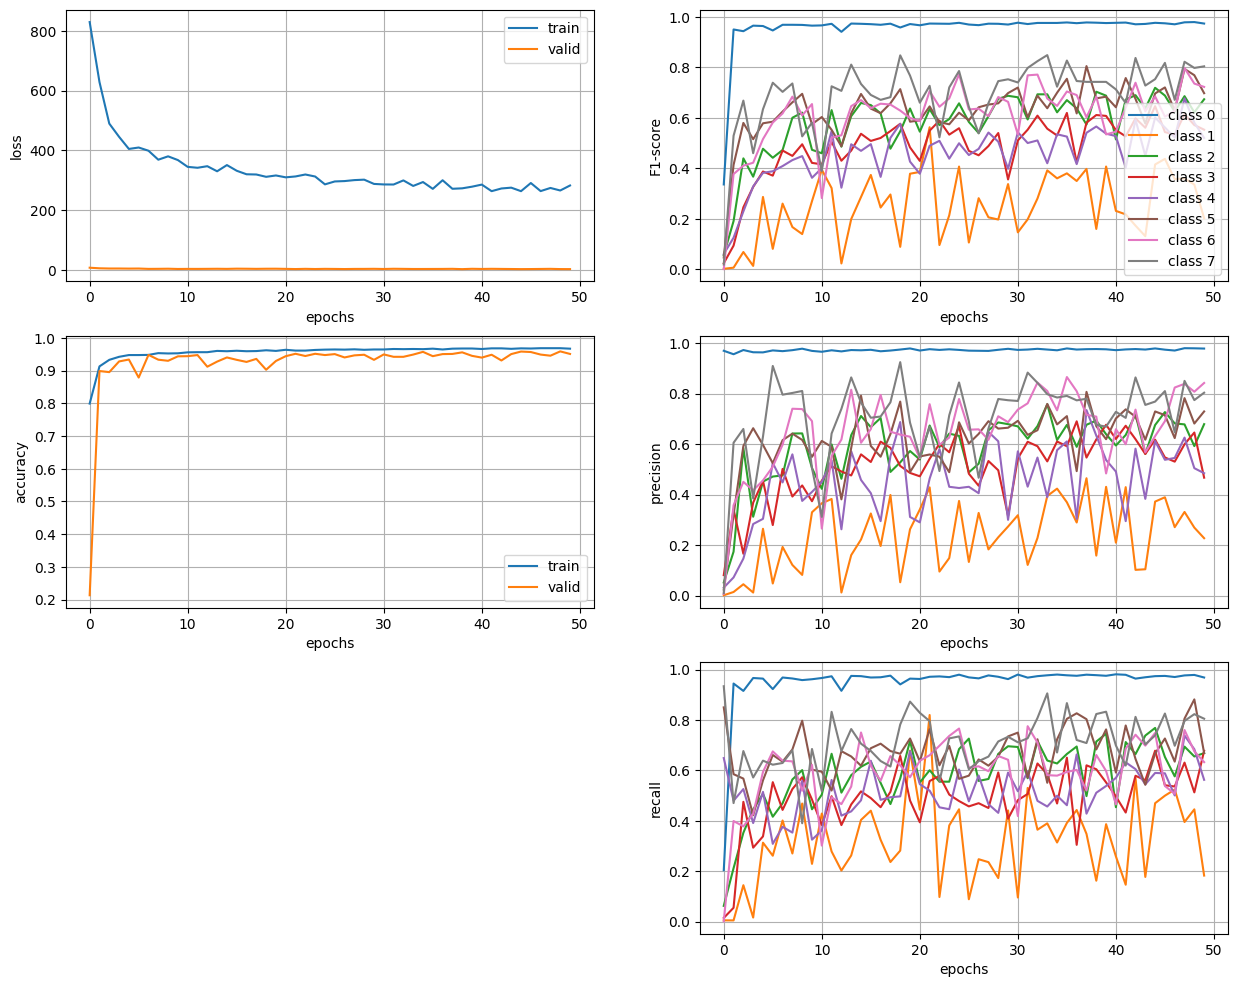

In [10]:
from deepfindET.utils import core
import h5py, os

# Set the path to the training history file
history_path = os.path.join(training_output_path, 'net_train_history.h5')

# Convert the HDF5 file containing the training history into a dictionary format
# This allows easy access to the training metrics like loss, accuracy, etc., stored during training
history = core.convert_hdf5_to_dictionary(history_path)

# Plot the training history to visualize the learning process
# The plot_history function will generate curves for metrics such as training and validation loss, accuracy, etc.
core.plot_history(history, save_figure=False)
plt.show()